In [1]:
import itertools
from pathlib import Path

import minisom
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import shapely

from plotly.colors import sample_colorscale, DEFAULT_PLOTLY_COLORS
from plotly.subplots import make_subplots
from plotly.figure_factory import create_dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics import davies_bouldin_score
from IPython.display import IFrame, Image

In [2]:
# Parameters
data_path = Path(r'data.csv')
input_columns = ['pH', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']

som_nx = 7
som_ny = 7
som_sigma = 1.5
som_learning_rate = 0.7
som_activation_distance = 'euclidean'
som_topology = 'hexagonal'
som_neighborhood_function = 'gaussian'
som_random_seed = 10
som_max_iterations = 3000

max_clusters = 10
number_of_clusters = 4  # Set to None to pick the optimal number automatically

# Visualization
pio.templates.default = 'plotly_white'
plotly_interactive = False

In [3]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))


In [4]:
# Read input data
df = pd.read_csv(data_path)
df.describe()

,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
count,102.0,102.0,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.000000,102.000000,102.000000
mean,0.6,30.0,7.680392,7.710784,12.067647,18.490196,2.057843,10.184314,0.0,8.826471,17.335294,2627.794118
std,0.0,0.0,0.214356,6.420371,6.753762,11.158325,1.243553,3.368454,0.0,10.335902,12.658083,1313.058242
min,0.6,30.0,6.300000,0.400000,1.200000,0.200000,0.000000,2.500000,0.0,1.000000,2.000000,856.000000
25%,0.6,30.0,7.600000,3.650000,8.000000,11.825000,1.300000,8.500000,0.0,4.400000,9.025000,1902.000000
50%,0.6,30.0,7.700000,6.600000,11.300000,16.050000,1.800000,10.350000,0.0,7.300000,13.800000,2452.000000
75%,0.6,30.0,7.800000,9.550000,15.000000,21.950000,2.400000,12.775000,0.0,9.750000,23.500000,2981.000000
max,0.6,30.0,8.400000,42.600000,58.400000,81.300000,9.000000,16.800000,0.0,78.000000,66.300000,9629.000000


In [5]:
df

,Sample,Label,Color,Marker,Alpha,Size,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
0,sample1,K-1,red,o,0.6,30,7.5,3.2,7.1,11.5,1.3,14.8,0,2.2,3.5,1483
1,sample2,K-1,red,o,0.6,30,7.7,2.6,7.0,13.0,1.4,13.3,0,3.8,3.2,1601
2,sample3,K-1,red,o,0.6,30,7.3,1.2,8.0,12.0,1.3,13.9,0,2.0,3.4,1542
3,sample4,K-1,red,o,0.6,30,7.4,2.2,6.6,12.6,1.4,13.6,0,2.4,3.1,1518
4,sample5,K-1,red,o,0.6,30,7.3,2.5,9.6,10.3,1.1,14.3,0,2.0,3.4,1476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,sample98,P-7,orange,o,0.6,30,7.9,1.8,2.4,3.8,0.4,4.0,0,1.0,3.4,856
98,sample99,P-8,cyan,o,0.6,30,7.5,12.2,14.0,8.6,1.0,5.5,0,6.0,23.4,2394
99,sample100,P-8,cyan,o,0.6,30,7.8,12.8,13.4,9.6,1.1,6.3,0,6.0,23.8,2456
100,sample101,P-8,cyan,o,0.6,30,7.8,11.6,12.0,11.4,1.3,5.2,0,6.2,23.8,2435


In [6]:
# Derive SOM dimensions
if som_nx is None or som_ny is None:
    som_m = 5 * np.sqrt(len(df))
    som_nx = np.round(np.sqrt(som_m)).astype(int)
    som_ny = np.round(som_m / som_nx).astype(int)

print(f"SOM dimensions: {som_nx} x {som_ny}")

SOM dimensions: 7 x 7


In [7]:
# Train the SOM model

# Set up data transform for input
input_array = df[input_columns].values

# Normalization:
# norm_b = input_array.min(axis=0)
# norm_a = input_array.max(axis=0) - norm_b

# Standardization
norm_b = input_array.mean(axis=0)
norm_a = input_array.std(axis=0)

data_transform = lambda x: (x - norm_b) / norm_a
inverse_data_transform = lambda y: norm_a * y + norm_b

# Set up model
som = minisom.MiniSom(
    som_nx,
    som_ny,
    len(input_columns),
    sigma=som_sigma,
    learning_rate=som_learning_rate,
    activation_distance=som_activation_distance,
    topology=som_topology,
    neighborhood_function=som_neighborhood_function,
    random_seed=som_random_seed,
)

# Train
som.train(data_transform(input_array), som_max_iterations)

# Extract data
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
win_map = som.win_map(data_transform(df[input_columns].values), return_indices=True)

In [8]:
# Create hexagons for visualization
def hexagon(_xx, _yy, radius):
    # Returns a NX x NY x 6 x 2 array of hexagon coordinates
    hex_xy = np.zeros((_xx.shape[0], _xx.shape[1], 7, 2))
    for i in range(7):
        theta = np.pi / 6 + 2 * np.pi * i / 6
        hex_xy[:, :, i, 0] = _xx + radius * np.cos(theta)
        hex_xy[:, :, i, 1] = _yy + radius * np.sin(theta)
    return hex_xy


hexagons = hexagon(xx, yy, 0.5)
hexagons.shape

(7, 7, 7, 2)

In [9]:
# Setup input to clustering and dendrogram plot
mij = np.meshgrid(np.arange(som_nx), np.arange(som_ny), indexing='ij')
cells_ij = np.column_stack((mij[0].flat, mij[1].flat))
labels = [(i, j) for i, j in cells_ij]
flat_weights = weights.reshape(-1, len(input_columns)) 

links = hierarchy.linkage(flat_weights, method='complete', metric='euclidean')


In [10]:
cluster_results = []

for i in range(2, max_clusters):
    flat_labels = hierarchy.fcluster(links, i, 'maxclust')
    DBI = davies_bouldin_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    cluster_results.append({
        "Number of clusters": i,
        "DBI": DBI,
        "labels": flat_labels,
    })

cluster_df = pd.DataFrame.from_dict(cluster_results)
optimal_cluster = cluster_df.iloc[cluster_df['DBI'].idxmin()]
if number_of_clusters is None:
    selected_cluster = optimal_cluster
else:
    selected_cluster = cluster_df[cluster_df['Number of clusters'] == number_of_clusters].iloc[0]

In [11]:
fig = px.line(cluster_df, x='Number of clusters', y='DBI', markers=True)
print(f"Optimal number of clusters: {optimal_cluster["Number of clusters"]}")
#fig.layout.title = f"Optimal number of clusters: {optimal_cluster['n_clusters']}"
fig

Optimal number of clusters: 2


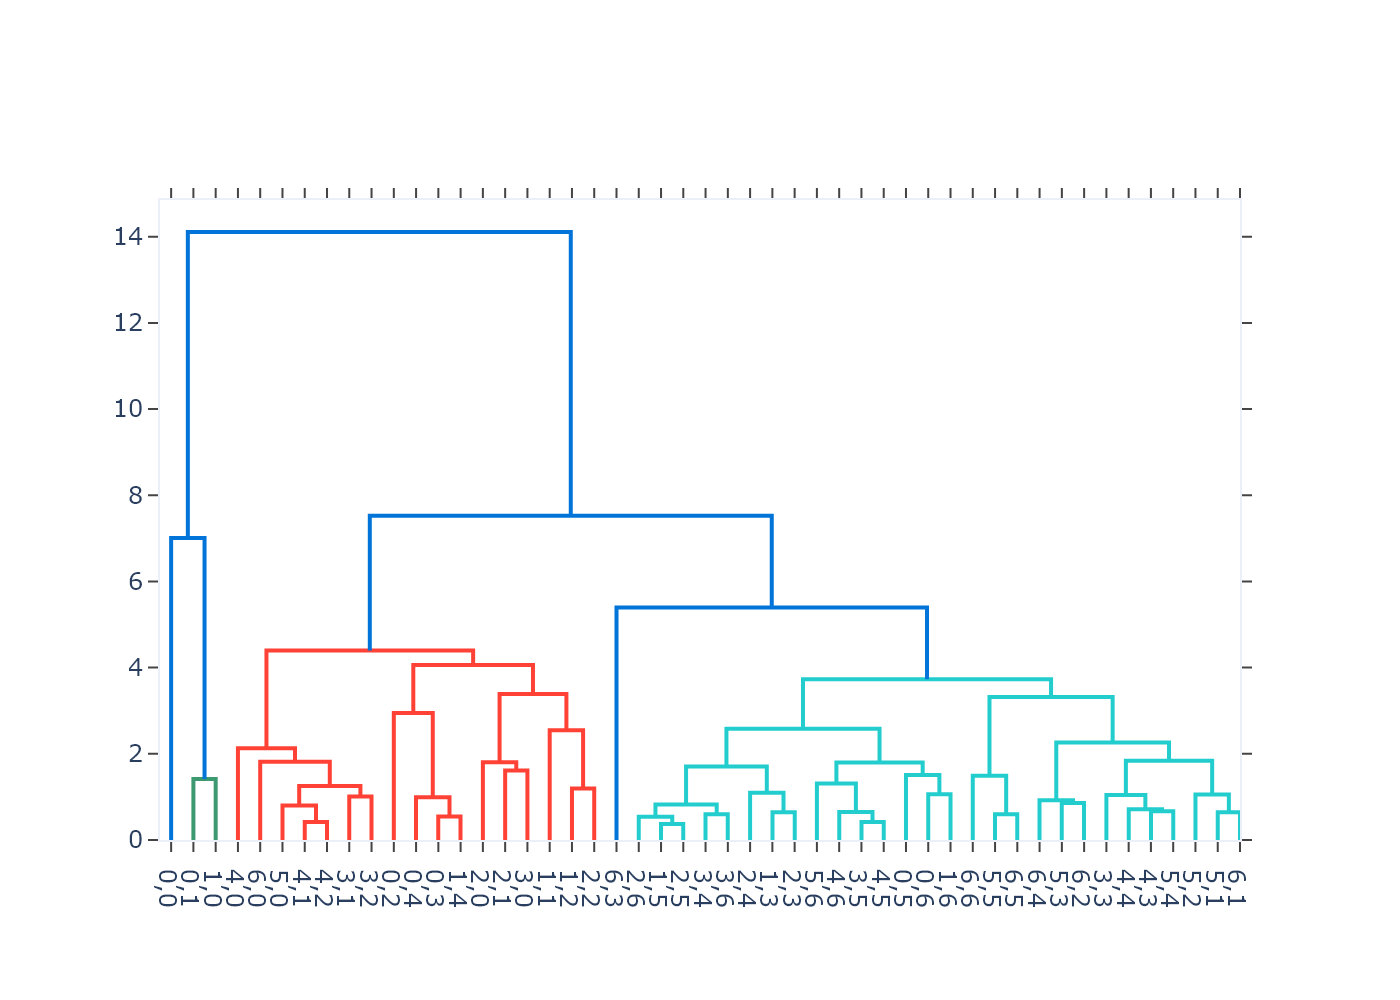

In [12]:
show_figure(create_dendrogram(
    flat_weights,
    linkagefun=lambda _: links,
    labels=labels,
    # NB! The color_threshold must be manually set to a value corresponding to the number of clusters
    color_threshold=5
))

In [13]:
# Optimal number of lables
node_labels = selected_cluster['labels'].reshape(som_nx, som_ny)

# Sample labels
sample_ij = [None] * len(df)
sample_label = [-1] * len(df)
for key, value in win_map.items():
    for ix in value:
        sample_ij[ix] = key
        sample_label[ix] = node_labels[key]

df['ij'] = sample_ij
df['cluster_label'] = sample_label

# Cluster polygons
node_hexagons = hexagon(xx, yy, np.sqrt(3) / 3 + 0.001).reshape(-1, 7, 2)
cluster_boundaries = {}
for c in np.unique(node_labels):
    matches = node_labels.flatten() == c
    joined_polygon = shapely.union_all([shapely.Polygon(p) for p in node_hexagons[matches]])
    cluster_boundaries[c] = joined_polygon

In [14]:
n_cols = 8
for lab, sub_df in df.groupby('cluster_label'):
    print(f"Cluster {lab}: {len(sub_df)} samples")
    for i, s in enumerate(sub_df['Sample']):
        print(f"  {s:19}", end="")
        if i % n_cols == n_cols - 1:
            print()
    print("\n")

Cluster 2: 2 samples
  sample38             sample39           

Cluster 3: 32 samples
  sample22             sample25             sample26             sample37             sample41             sample43             sample44             sample45           
  sample46             sample47             sample54             sample58             sample64             sample65             sample71             sample72           
  sample73             sample74             sample75             sample76             sample77             sample78             sample80             sample81           
  sample83             sample84             sample85             sample86             sample88             sample89             sample90             sample93           


Cluster 4: 68 samples
  sample1              sample2              sample3              sample4              sample5              sample6              sample7              sample8            
  sample9              sample10             

# Plotting and Visualization

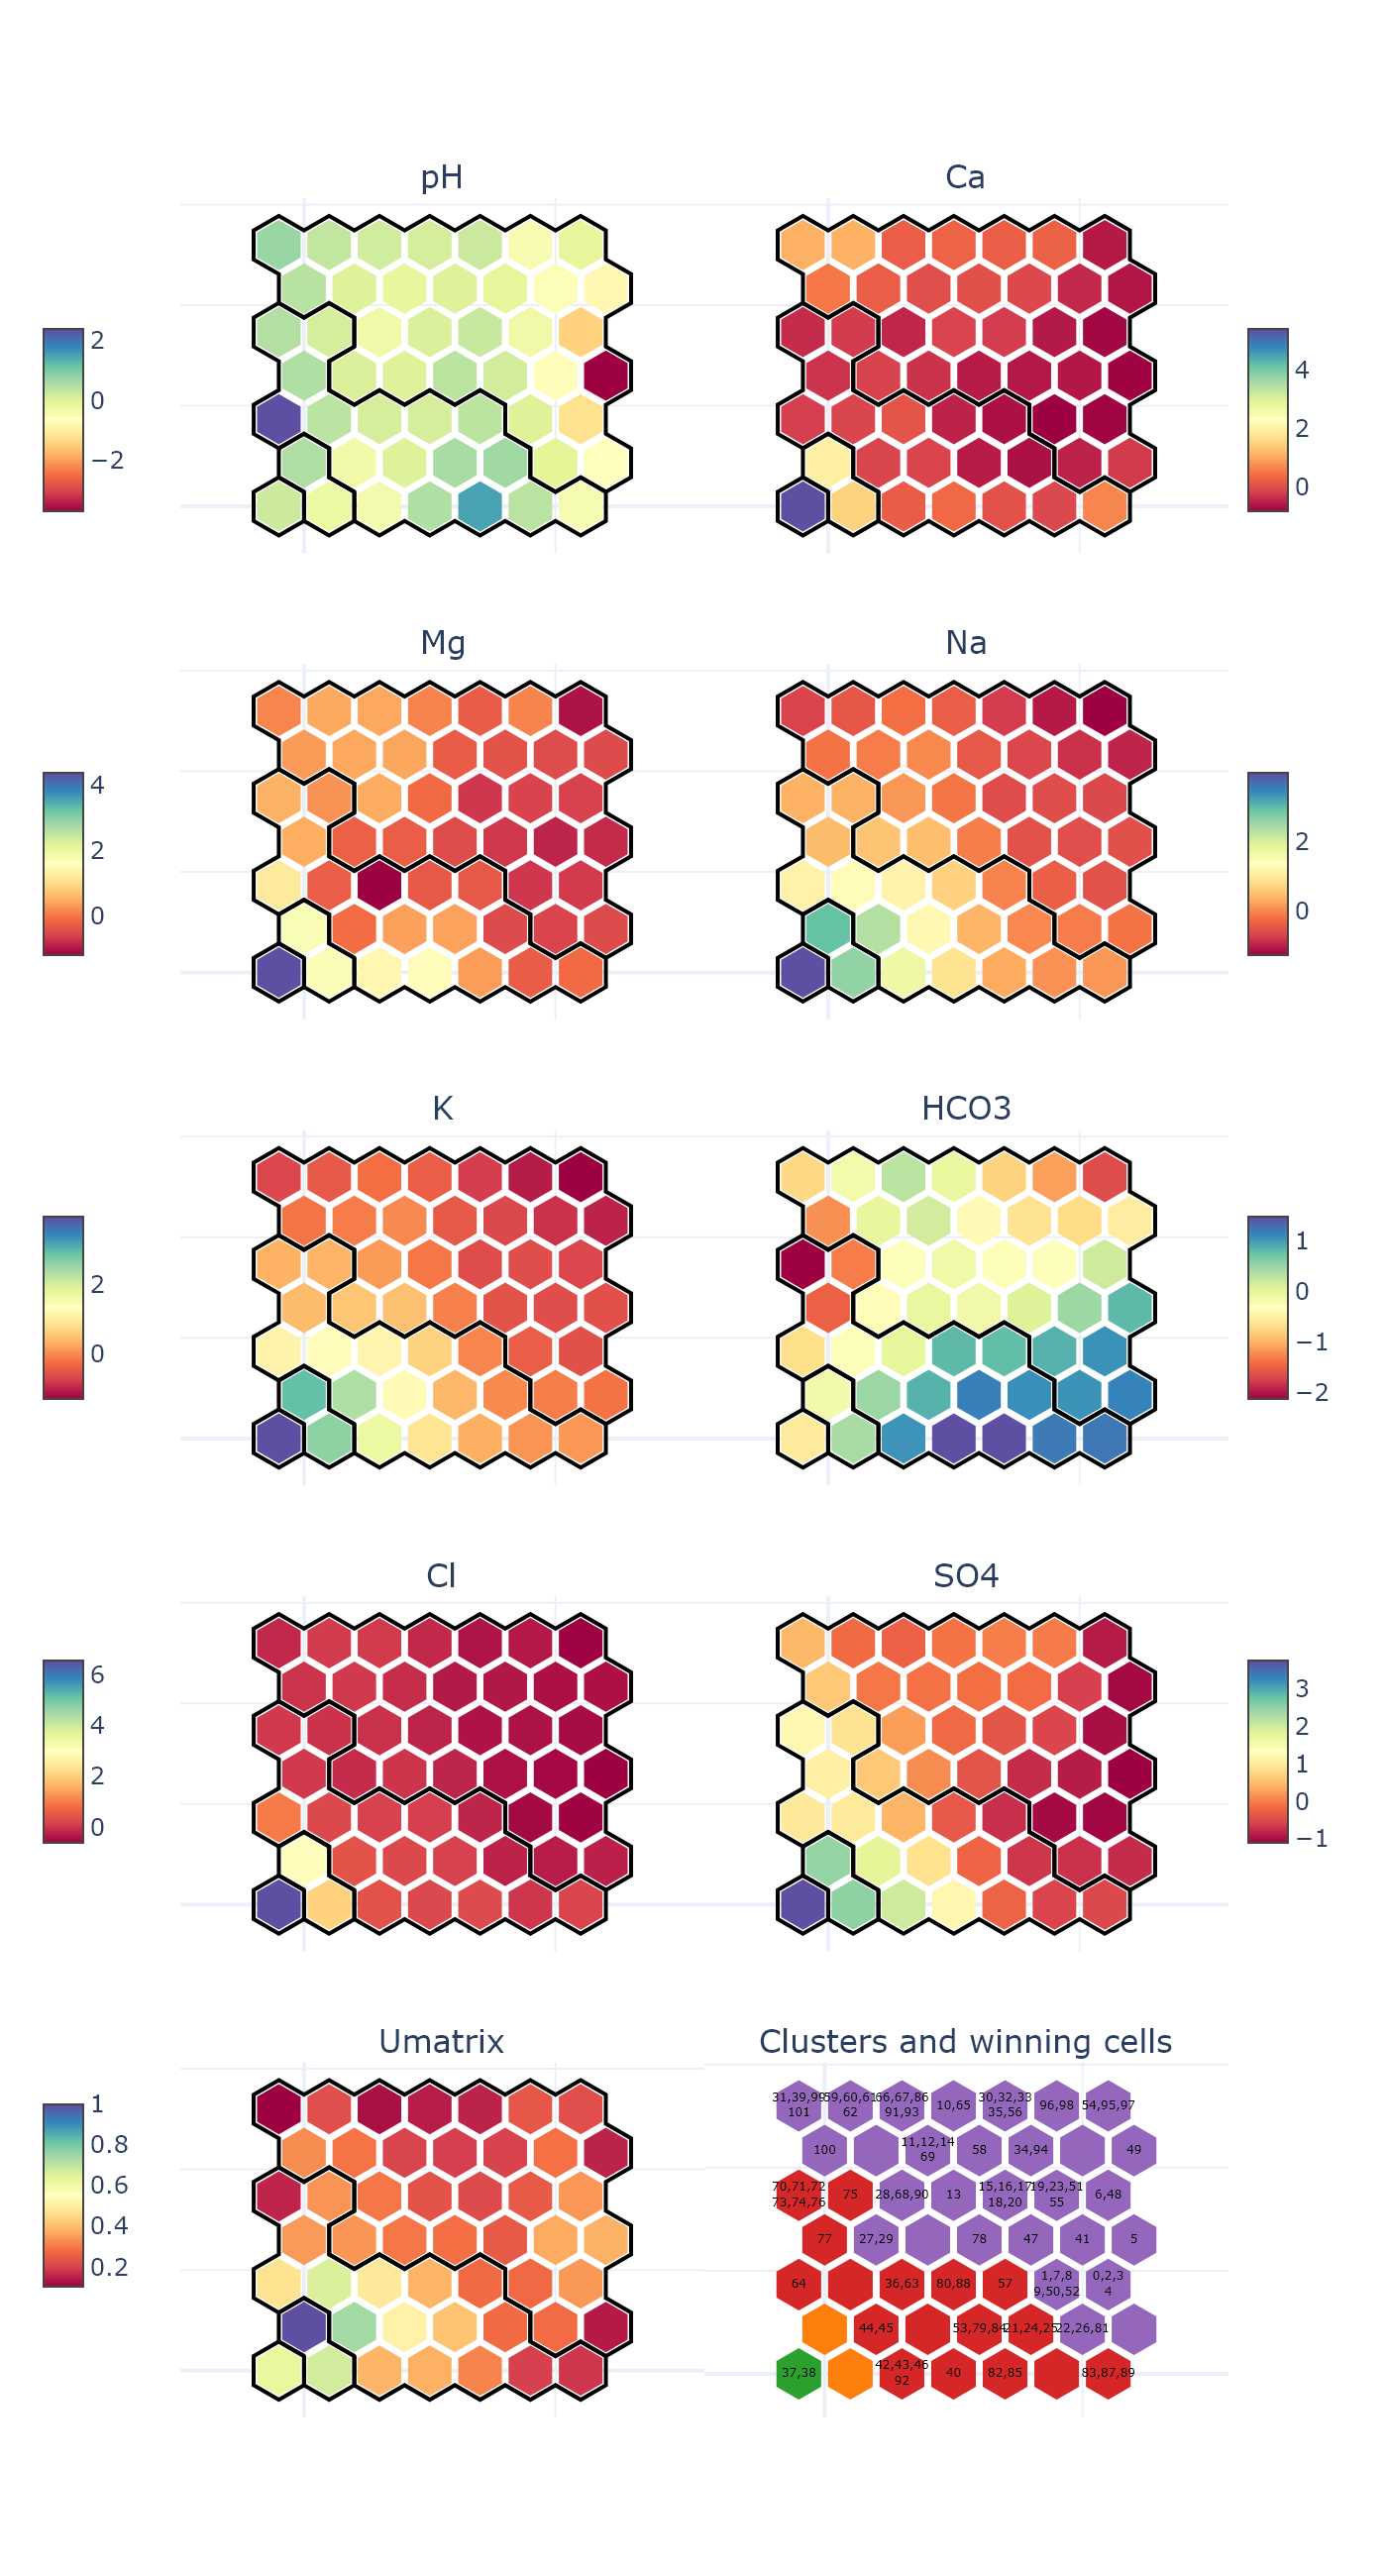

In [15]:
# Define functions for plotting
def add_cluster_boundaries(fig: go.Figure, row_index, col_index):
    for k, boundary in cluster_boundaries.items():
        
        if boundary.geom_type == 'Polygon':
            bnds = [boundary]
        elif boundary.geom_type == 'MultiPolygon':
            bnds = list(boundary.geoms)
        else:
            raise NotImplementedError(boundary.geom_type)
        
        for poly in bnds:
            if poly.boundary.geom_type == 'LineString':
                crds = np.array(poly.boundary.coords)
            else:
                crds = np.array(poly.boundary.geoms[0].coords)

            fig.add_scatter(
                x=crds[:, 0],
                y=crds[:, 1],
                # fill='toself',
                mode="lines",
                showlegend=False,
                line=dict(color='black', width=2),
                row=row_index,
                col=col_index,
            )


def add_som_features(fig: go.Figure, row, col, feature_index, colorbar_settings):
    if feature_index >= weights.shape[2]:
        w = umatrix.copy()
    else:
        # Applying inverse_data_transform will re-scale the features to their original scale
        # w = inverse_data_transform(weights)[:, :, feature_index]
        w = weights[:, :, feature_index]

    w_min = w.min()
    w_max = w.max()
    w -= w.min()
    w /= w.max()
    colors = np.array(
        sample_colorscale('spectral', w.flatten())
    ).reshape(som_nx, som_ny)

    # Add colored hexagons
    for i in range(som_nx):
        for j in range(som_ny):
            text = str(sorted(df.iloc[win_map[(i, j)]].index.values.tolist()))

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=colors[i, j],
                line=dict(color='black', width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )
           
    fig.add_scatter(
        x=[0, 0],
        y=[0, 0],
        showlegend=False,
        marker=dict(color=[w_min, w_max], colorscale="spectral", size=0.001, colorbar=colorbar_settings),
        row=row,
        col=col,
    )


def add_training_cells(fig: go.Figure, row, col):
    # Add colored hexagons
    label_colors = DEFAULT_PLOTLY_COLORS
    for i in range(som_nx):
        for j in range(som_ny):
            text = ""
            if len(win_map[(i, j)]) > 0:
                samples = [str(s) for s in sorted(df.iloc[win_map[(i, j)]].index.values.tolist())]
                if len(samples) <= 3:
                    text = f"{','.join(samples)}"
                elif len(samples) <= 6:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:])}"
                elif len(samples) <= 9:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:6])}" + f"<br>{','.join(samples[6:])}"
                else:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:-3])}" + f"<br>{','.join(samples[-3:])}"

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=label_colors[node_labels[i, j]],
                line=dict(width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )

            mid = (hexagons[i, j, 0, :] + hexagons[i, j, 3, :]) / 2
            fig.add_scatter(
                x=[mid[0]],
                y=[mid[1]],
                mode="text",
                text=text,
                textfont=dict(color="black", size=6),
                marker=dict(color='black'),
                showlegend=False,
                hoverinfo="none",
                row=row,
                col=col,
            )


n_plots = len(input_columns) + 2
subplot_rows = (n_plots + 1) // 2
subplot_columns = 2
features_fig = make_subplots(
    rows=subplot_rows,
    cols=subplot_columns,
    subplot_titles=input_columns + ["Umatrix"] + ["Clusters and winning cells"],
    horizontal_spacing=0,
    vertical_spacing=0.05,

)
features_fig.layout.height = 50 + 250 * subplot_rows

subplot_ix = list(
    itertools.product(range(1, subplot_rows + 1), range(1, subplot_columns + 1))
)[:n_plots]

# Feature plots
for i, (row_index, col_index) in enumerate(subplot_ix[:len(input_columns)+1]):
    add_cluster_boundaries(features_fig, row_index, col_index)
    colorbar_settings = dict(
        thickness = 20,
        len = 0.5 * (1 / subplot_rows),
        y = 1 - (row_index - 0.5) / subplot_rows,
        x = -0.15 if col_index == 1 else 1
    )
    add_som_features(features_fig, row_index, col_index, i, colorbar_settings)

add_training_cells(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])


for i, (row_index, col_index) in enumerate(subplot_ix):
    sp = features_fig.get_subplot(row_index, col_index)
    sp.yaxis.scaleanchor = sp.yaxis.anchor
    sp.yaxis.showticklabels = False
    sp.xaxis.showticklabels = False


show_figure(features_fig)

In [16]:
# Calculate percentages for Piper diagram
sum_cations = df[['Ca', 'Mg', 'K', 'Na']].sum(axis=1)
sum_anions = df[['Cl', 'SO4', 'CO3', 'HCO3']].sum(axis=1)

df['Ca%'] = df['Ca'] / sum_cations
df['Mg%'] = df['Mg'] / sum_cations
df['K+Na%'] = (df['K'] + df['Na']) / sum_cations

df['Cl%'] = df['Cl'] / sum_anions
df['SO4%'] = df['SO4'] / sum_anions
df['CO3+HCO3%'] = (df['CO3'] + df['HCO3']) / sum_anions


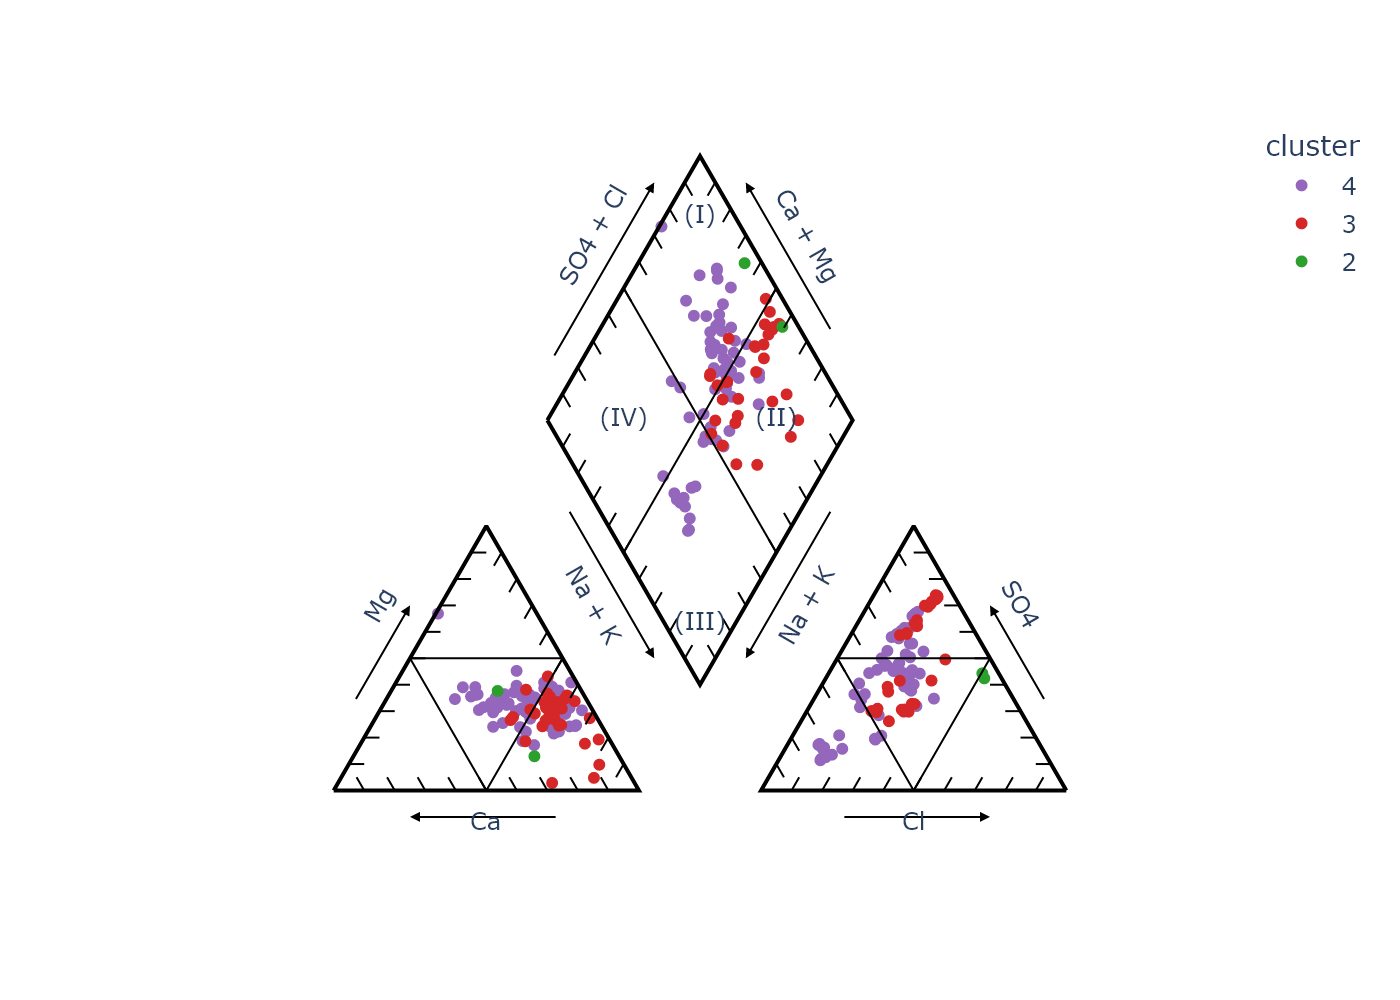

In [17]:
# ------------------------------------------------------------
# Figure settings
# ------------------------------------------------------------

axis_length = 10
theta = np.pi/3
line_color = "black"
gap = 0.4
tick_length = 0.05
arrow_args = dict(
    axref="x",
    ayref="y",
    showarrow=True,
    arrowhead=2,
    arrowcolor=line_color,
)
arrow_txt_args = dict(
    showarrow=False,
)
outer_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=2),
    showlegend=False,
)
inner_axis_args = dict(
    mode="lines",
    line=dict(color=line_color, width=1),
    showlegend=False,
)

diamond_u = axis_length * np.array([np.cos(-theta), np.sin(-theta)])
diamond_v = axis_length * np.array([np.cos(theta), np.sin(theta)])

lowerleft_v = diamond_v.copy()
lowerleft_u = np.array([axis_length, 0])
lowerleft_w = -diamond_u
lowerleft_o = np.zeros_like(lowerleft_v)

diamond_o = lowerleft_o + (1 + gap) * diamond_v
lowerright_o = lowerleft_o + (2 + gap)  * diamond_v + (2 + gap) * diamond_u
lowerright_u = -lowerleft_u
lowerright_v = -diamond_u
lowerright_w = lowerleft_v

ticks = np.arange(1, 10) * 0.1

# ------------------------------------------------------------
# Setup data and initial plot
# ------------------------------------------------------------

# Lower left data
data_lowerleft = (
    lowerleft_o[:, np.newaxis]
    + (1 - (df['Ca%'])).values * lowerleft_u[:, np.newaxis]
    + df['Mg%'].values * lowerleft_w[:, np.newaxis]
).T

# Lower right data
data_lowerright = (
    lowerright_o[:, np.newaxis]
    + (1 - (df['Cl%'])).values * lowerright_u[:, np.newaxis]
    + df['SO4%'].values * lowerright_w[:, np.newaxis]
).T

# Diamond data
data_diamond = (
    diamond_o[:, np.newaxis]
    + df['K+Na%'].values * diamond_u[:, np.newaxis]
    + (df['SO4%'] + df['Cl%']).values * diamond_v[:, np.newaxis]
).T

xy_data = np.vstack((data_lowerleft, data_lowerright, data_diamond))
plotting_df = pd.DataFrame(xy_data, columns=['x', 'y'])
plotting_df['cluster'] = np.hstack([df['cluster_label'].values.tolist()] * 3).astype(str)
color_map = {str(i): c for i, c in enumerate(DEFAULT_PLOTLY_COLORS)}
fig_piper = px.scatter(plotting_df, x="x", y="y", color="cluster", color_discrete_map=color_map)

# ------------------------------------------------------------
# Lower-left triangle
# ------------------------------------------------------------

ll_axis = np.array([
    lowerleft_o,
    lowerleft_o + lowerleft_v,
    lowerleft_o + lowerleft_u,
    lowerleft_o,
])
ll_tri = np.array([
    lowerleft_o + 0.5 * lowerleft_u,
    lowerleft_o + 0.5 * lowerleft_u + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_v,
    lowerleft_o + 0.5 * lowerleft_u,
])
# Ticks, left side
ll_tick_l0 = lowerleft_o + lowerleft_v * ticks[:, np.newaxis]
ll_tick_l1 = ll_tick_l0 + tick_length * lowerleft_u
ll_tick_left = np.full((ll_tick_l0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_left[::3] = ll_tick_l0
ll_tick_left[1::3] = ll_tick_l1
# Ticks, bottom
ll_tick_b0 = lowerleft_o + lowerleft_u * ticks[:, np.newaxis]
ll_tick_b1 = ll_tick_b0 + tick_length * lowerleft_w
ll_tick_bot = np.full((ll_tick_b0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_bot[::3] = ll_tick_b0
ll_tick_bot[1::3] = ll_tick_b1
# Ticks, right side
ll_tick_r0 = lowerleft_o + lowerleft_u + lowerleft_w * ticks[:, np.newaxis]
ll_tick_r1 = ll_tick_r0 - tick_length * lowerleft_v
ll_tick_right = np.full((ll_tick_r0.shape[0] * 3, 2), fill_value=np.nan)
ll_tick_right[::3] = ll_tick_r0
ll_tick_right[1::3] = ll_tick_r1
# All ticks merged
ll_all_ticks = np.vstack((ll_tick_left, ll_tick_bot, ll_tick_right))

fig_piper.add_scatter(
    x=ll_axis[:, 0],
    y=ll_axis[:, 1],
    **outer_axis_args,
)
fig_piper.add_scatter(
    x=ll_tri[:, 0],
    y=ll_tri[:, 1],
    **inner_axis_args,
)
fig_piper.add_scatter(
    x=ll_all_ticks[:, 0],
    y=ll_all_ticks[:, 1],
    **inner_axis_args,
)
lowerleft_arrows = np.array([
    # Mg
    lowerleft_o - 0.1 * lowerleft_u + 0.3 * lowerleft_v,
    lowerleft_o - 0.1 * lowerleft_u + 0.7 * lowerleft_v,
    # Ca
    lowerleft_o + 0.8 * lowerleft_u - 0.1 * lowerleft_v,
    lowerleft_o + 0.3 * lowerleft_u - 0.1 * lowerleft_v,
])
fig_piper.add_annotation(
    x=lowerleft_arrows[1, 0],
    y=lowerleft_arrows[1, 1],
    ax=lowerleft_arrows[0, 0],
    ay=lowerleft_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_arrows[3, 0],
    y=lowerleft_arrows[3, 1],
    ax=lowerleft_arrows[2, 0],
    ay=lowerleft_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerleft_o[0] + 0.5 * lowerleft_u[0],
    y=lowerleft_o[1] - 0.1 * axis_length,
    text="Ca",
    showarrow=False,
)
arrow_text_mg = lowerleft_o - 0.2 * lowerleft_u + 0.7 * lowerleft_v 
fig_piper.add_annotation(
    x=arrow_text_mg[0],
    y=arrow_text_mg[1],
    text="Mg",
    textangle=-60,
    showarrow=False,
)

# ------------------------------------------------------------
# Lower right triangle
# ------------------------------------------------------------

lr_axis = np.array([
    lowerright_o,
    lowerright_o + lowerright_v,
    lowerright_o + lowerright_u,
    lowerright_o,
])
lr_tri = np.array([
    lowerright_o + 0.5 * lowerright_u,
    lowerright_o + 0.5 * lowerright_u + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_v,
    lowerright_o + 0.5 * lowerright_u,
])

# Ticks, right side
lr_tick_l0 = lowerright_o + lowerright_v * ticks[:, np.newaxis]
lr_tick_l1 = lr_tick_l0 + tick_length * lowerright_u
lr_tick_left = np.full((lr_tick_l0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_left[::3] = lr_tick_l0
lr_tick_left[1::3] = lr_tick_l1
# Ticks, bottom
lr_tick_b0 = lowerright_o + lowerright_u * ticks[:, np.newaxis]
lr_tick_b1 = lr_tick_b0 + tick_length * lowerright_w
lr_tick_bot = np.full((lr_tick_b0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_bot[::3] = lr_tick_b0
lr_tick_bot[1::3] = lr_tick_b1
# Ticks, left side
lr_tick_r0 = lowerright_o + lowerright_u + lowerright_w * ticks[:, np.newaxis]
lr_tick_r1 = lr_tick_r0 - tick_length * lowerright_v
lr_tick_right = np.full((lr_tick_r0.shape[0] * 3, 2), fill_value=np.nan)
lr_tick_right[::3] = lr_tick_r0
lr_tick_right[1::3] = lr_tick_r1
# All ticks merged
lr_all_ticks = np.vstack((lr_tick_left, lr_tick_bot, lr_tick_right))

fig_piper.add_scatter(
    x=lr_all_ticks[:, 0],
    y=lr_all_ticks[:, 1],
    **inner_axis_args,
)
fig_piper.add_scatter(
    x=lr_axis[:, 0],
    y=lr_axis[:, 1],
    **outer_axis_args,
)
fig_piper.add_scatter(
    x=lr_tri[:, 0],
    y=lr_tri[:, 1],
    **inner_axis_args,
)

lowerright_arrows = np.array([
    # Mg
    lowerright_o - 0.1 * lowerright_u + 0.3 * lowerright_v,
    lowerright_o - 0.1 * lowerright_u + 0.7 * lowerright_v,
    # Ca
    lowerright_o + 0.8 * lowerright_u - 0.1 * lowerright_v,
    lowerright_o + 0.3 * lowerright_u - 0.1 * lowerright_v,
])

fig_piper.add_annotation(
    x=lowerright_arrows[1, 0],
    y=lowerright_arrows[1, 1],
    ax=lowerright_arrows[0, 0],
    ay=lowerright_arrows[0, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_arrows[3, 0],
    y=lowerright_arrows[3, 1],
    ax=lowerright_arrows[2, 0],
    ay=lowerright_arrows[2, 1],
    **arrow_args,
)
fig_piper.add_annotation(
    x=lowerright_o[0] + 0.5 * lowerright_u[0],
    y=lowerright_o[1] - 0.1 * axis_length,
    text="Cl",
    showarrow=False,
)
arrow_text_so4 = lowerright_o - 0.2 * lowerright_u + 0.7 * lowerright_v 
fig_piper.add_annotation(
    x=arrow_text_so4[0],
    y=arrow_text_so4[1],
    text="SO4",
    textangle=60,
    showarrow=False,
)

# ------------------------------------------------------------
# Diamond axis parameters
# ------------------------------------------------------------

# Diamond axes
axis_xy = np.array([
    diamond_o,
    diamond_o + diamond_v,
    diamond_o + diamond_v + diamond_u,
    diamond_o + diamond_u,
    diamond_o,
])
fig_piper.add_scatter(
    x=axis_xy[:, 0],
    y=axis_xy[:, 1],
    **outer_axis_args,
)

# Diamond Cross
cross_xy = np.array([
    diamond_o + 0.5 * diamond_u,
    diamond_o + 0.5 * diamond_u + diamond_v,
    [None, None],
    diamond_o + 0.5 * diamond_v,
    diamond_o + 0.5 * diamond_v + diamond_u
])
fig_piper.add_scatter(
    x=cross_xy[:, 0],
    y=cross_xy[:, 1],
    **inner_axis_args,    
)

# Diamond ticks
nw_ticks0 = diamond_o + diamond_v * ticks[:, np.newaxis]
sw_ticks0 = diamond_o + diamond_u * ticks[:, np.newaxis]
ne_ticks0 = diamond_o + diamond_v + diamond_u * ticks[:, np.newaxis]
se_ticks0 = diamond_o + diamond_u + diamond_v * ticks[:, np.newaxis]
nw_ticks1 = nw_ticks0 + diamond_u * tick_length
sw_ticks1 = sw_ticks0 + diamond_v * tick_length
ne_ticks1 = ne_ticks0 - diamond_v * tick_length
se_ticks1 = se_ticks0 - diamond_u * tick_length
nw_ticks = np.full((nw_ticks0.shape[0] * 3, 2), fill_value=np.nan)
nw_ticks[::3] = nw_ticks0
nw_ticks[1::3] = nw_ticks1
sw_ticks = np.full((sw_ticks0.shape[0] * 3, 2), fill_value=np.nan)
sw_ticks[::3] = sw_ticks0
sw_ticks[1::3] = sw_ticks1
ne_ticks = np.full((ne_ticks0.shape[0] * 3, 2), fill_value=np.nan)
ne_ticks[::3] = ne_ticks0
ne_ticks[1::3] = ne_ticks1
se_ticks = np.full((se_ticks0.shape[0] * 3, 2), fill_value=np.nan)
se_ticks[::3] = se_ticks0
se_ticks[1::3] = se_ticks1
diamond_ticks = np.vstack((nw_ticks, se_ticks, ne_ticks, sw_ticks))
fig_piper.add_scatter(
    x=diamond_ticks[:, 0],
    y=diamond_ticks[:, 1],
    **inner_axis_args,
)

# Diamond roman text
romans_xy = np.array([
    diamond_o + diamond_v - np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.75 * axis_length, 0]),
    diamond_o + diamond_u + np.array([0, 0.2 * axis_length]),
    diamond_o + np.array([0.25 * axis_length, 0]),
])
fig_piper.add_scatter(
    x=romans_xy[:, 0],
    y=romans_xy[:, 1],
    text=["(I)", "(II)", "(III)", "(IV)"],
    mode="text",
    showlegend=False,
)

# Diamond arrows and text
arrows = np.array([
    # SO4 + Cl
    diamond_o + -0.1 * diamond_u + 0.1 * diamond_v,
    diamond_o + -0.1 * diamond_u + 0.8 * diamond_v,
    # Ca + Mg
    diamond_o + 1.1 * diamond_v + 0.8 * diamond_u,
    diamond_o + 1.1 * diamond_v + 0.2 * diamond_u,
    # Na + K
    diamond_o + -0.1 * diamond_v + 0.2 * diamond_u,
    diamond_o + -0.1 * diamond_v + 0.8 * diamond_u,
    # HCO3 + CO3
    diamond_o + 1.1 * diamond_u + 0.8 * diamond_v,
    diamond_o + 1.1 * diamond_u + 0.2 * diamond_v,
])
for i in range(0, 8, 2):
    fig_piper.add_annotation(
        x=arrows[i + 1, 0],
        y=arrows[i + 1, 1],
        ax=arrows[i, 0],
        ay=arrows[i, 1],
        **arrow_args
    )
    
arrow_txt1 = diamond_o + -0.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt1[0],
    y=arrow_txt1[1],
    text="SO4 + Cl",
    textangle=-60,
    **arrow_txt_args
)
arrow_txt2 = diamond_o + 0.5 * diamond_u + 1.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt2[0],
    y=arrow_txt2[1],
    text="Ca + Mg",
    textangle=60,
    **arrow_txt_args
)
arrow_txt3 = diamond_o + 0.5 * diamond_u - 0.2 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt3[0],
    y=arrow_txt3[1],
    text="Na + K",
    textangle=60,
    **arrow_txt_args
)
arrow_txt4 = diamond_o + 1.2 * diamond_u + 0.5 * diamond_v
fig_piper.add_annotation(
    x=arrow_txt4[0],
    y=arrow_txt4[1],
    text="Na + K",
    textangle=-60,
    **arrow_txt_args
)

# ------------------------------------------------------------
# Final layout adjustments
# ------------------------------------------------------------
fig_piper.layout.yaxis.scaleanchor = 'x'
fig_piper.layout.xaxis.showgrid = False
fig_piper.layout.xaxis.zeroline = False
fig_piper.layout.xaxis.showticklabels = False
fig_piper.layout.xaxis.title = None
fig_piper.layout.yaxis.showgrid = False
fig_piper.layout.yaxis.zeroline = False
fig_piper.layout.yaxis.showticklabels = False
fig_piper.layout.yaxis.title = None

show_figure(fig_piper)


# TODO:

- ✅ Remove test-train split. Can re-introduce later if we consider it relevant
- ✅ Cluster count analysis. Refer to other sources/papers for common techniques. Include relevant plots
- ⬜ Clustering on HCA results or log-standardized input?
- ✅ Remove conversion to meq/L (data should already be converted)
- ✅ Hexagonal cluster plot with correct colors
- ⬜ Piper diagram:
  - ✅ Sync colors in piper diagram with dendrogram
  - ✅ Axis ticks
  - ⬜ Legend with roman numerals and "water type"
  - ⬜ Sort legend by cluster
- ⬜ Gibbs diagram
